# Nathan Fernandes

## Project - CS 767

# Importing Dependencies

In [1]:
import gym 
import random

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam, RMSprop

from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy, BoltzmannQPolicy

/Users/nathan/opt/anaconda3/envs/machine_lr/lib/python3.9/site-packages/ale_py/roms/__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()


## Building environment using Open AI Gym

In [2]:
env = gym.make('SpaceInvaders-v0')

# Taking height, width and channels from  environment, that gives the image shape
height, width, channels = env.observation_space.shape
actions = env.action_space.n

A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]


In [3]:
actions

6

In [4]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

**NOOP** - It's not actualy doing anything    
**FIRE** - Firing the cannon at 90 degrees     
**RIGHT** - Move one step to the right    
**LEFT** - Move one step to the left   
**RIGHTFIRE** - Firing the cannon to the right    
**LEFTFIRE** - Firing the cannon to the left

Running through random steps to see how a pre trained model works     
Trying   10 different games    


In [4]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = random.choice([0,1,2,3,4,5]) # going to choose any of the 6 actions randomly
        n_state, reward, done, info = env.step(action) # Taking the random action and applying it on our environment
        score+=reward # Append the score
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

/Users/nathan/opt/anaconda3/envs/machine_lr/lib/python3.9/site-packages/gym/envs/atari/environment.py:255: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(
2021-11-30 16:06:37.467 python[29080:308386] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa742771ef0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-30 16:06:37.467 python[29080:308386] Warning: Expected min height of view: (<NSButton: 0x7fa741e8b3e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-30 16:06:37.471 python[29080:308386] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa741e71e20>) to be less than or equal to 30 but got 

Episode:1 Score:20.0
Episode:2 Score:210.0
Episode:3 Score:160.0
Episode:4 Score:215.0
Episode:5 Score:110.0


# Building Model

Building a convolution layered Neural Network

I am going to extract height, width and channels from our environment     
What we get back from our state is actually an image, so I used a Convolution Layer to scan through that image and see how my model is performing and then flatten it down     
We start by training 32 Convolution Filters. These filters are going to be 8 units by 8 units    
4 x 4 ar the number of strides of the filter. Therefore if my images is 8x8 and my filter is 4x4, it will scan the image 4 steps to the right and 4 steps down.     
Then I've used the 'relu' activation function.     
Then I'm passing all of these frames from my reinforcement learning model to my deep learning model    
That's the first Convolution Layer    
The next Layer has 64, 4x4 filters
I then passed it to the Dense Layer. They are also know as fully connected layers, that means that each unit in that layer is connected to every single unit in the next.    
At the last layer, I passed on the number of action the model can take. We know that to be 6.

In [4]:
def model_test(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [13]:
del model

In [5]:
model = model_test(height, width, channels, actions)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 51, 39, 32)     6176      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 24, 18, 64)     32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 22, 16, 64)     36928     
_________________________________________________________________
flatten (Flatten)            (None, 67584)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               34603520  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

# Building Keras-RL Agent

Using a Dueling DQN Agent

**"DQNAgent"**    
*This is the reinforcement agent I am using*    

**"SequentialMemory"**     
*This allows us to hold a knowledge buffer of our previous games or our reinforcement agent*    

**"LinearAnnealedPolicy"**    
*Gives us a bit of decay. Linear Annealing Policy computes a current threshold value and
    transfers it to an inner policy which chooses the action.*

**"EpsGreedyQPolicy"**  
*Allows to find the best reward outcome*    

A Policy is basically what the agent does to accomplish it's goal, given it's state

In [15]:
def agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=1000, window_length=3) #This states that we are going to store the past 3 windows for a 1000 episodes 
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000
                  )
    return dqn

Then I set up a dueling network, this basically sets up a competing network for our reinforcement model

In [16]:
dqn = agent(model, actions)
dqn.compile(Adam(lr=1e-4))

In [23]:
dqn.fit(env, nb_steps=5000, visualize=False, verbose=2)

Training for 5000 steps ...
  627/5000: episode: 1, duration: 17.207s, episode steps: 627, steps per second:  36, episode reward: 110.000, mean reward:  0.175 [ 0.000, 30.000], mean action: 2.628 [0.000, 5.000],  loss: --, mean_q: --, mean_eps: --


/Users/nathan/opt/anaconda3/envs/machine_lr/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


done, took 322.197 seconds


In [18]:
scores = dqn.test(env, nb_episodes=100, visualize=True)
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...


/Users/nathan/opt/anaconda3/envs/machine_lr/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/nathan/opt/anaconda3/envs/machine_lr/lib/python3.9/site-packages/gym/envs/atari/environment.py:255: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(
2021-12-08 02:48:20.441 python[23095:1419134] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f7e1ca84820>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-12-08 02:48:20.442 python[23095:1419134] Warnin

Episode 1: reward: 265.000, steps: 1144
Episode 2: reward: 445.000, steps: 1227
Episode 3: reward: 210.000, steps: 1223
Episode 4: reward: 250.000, steps: 1101
Episode 5: reward: 225.000, steps: 517
Episode 6: reward: 305.000, steps: 1150
Episode 7: reward: 90.000, steps: 516
Episode 8: reward: 105.000, steps: 680
Episode 9: reward: 160.000, steps: 661
Episode 10: reward: 210.000, steps: 749
Episode 11: reward: 195.000, steps: 636
Episode 12: reward: 165.000, steps: 621
Episode 13: reward: 35.000, steps: 383
Episode 14: reward: 215.000, steps: 1153
Episode 15: reward: 150.000, steps: 636
Episode 16: reward: 170.000, steps: 590
Episode 17: reward: 150.000, steps: 742
Episode 18: reward: 190.000, steps: 572
Episode 19: reward: 195.000, steps: 674
Episode 20: reward: 290.000, steps: 1089
Episode 21: reward: 635.000, steps: 1156
Episode 22: reward: 235.000, steps: 848
Episode 23: reward: 220.000, steps: 1106
Episode 24: reward: 775.000, steps: 1213
Episode 25: reward: 220.000, steps: 588
E

In [11]:
import matplotlib.pyplot as plt

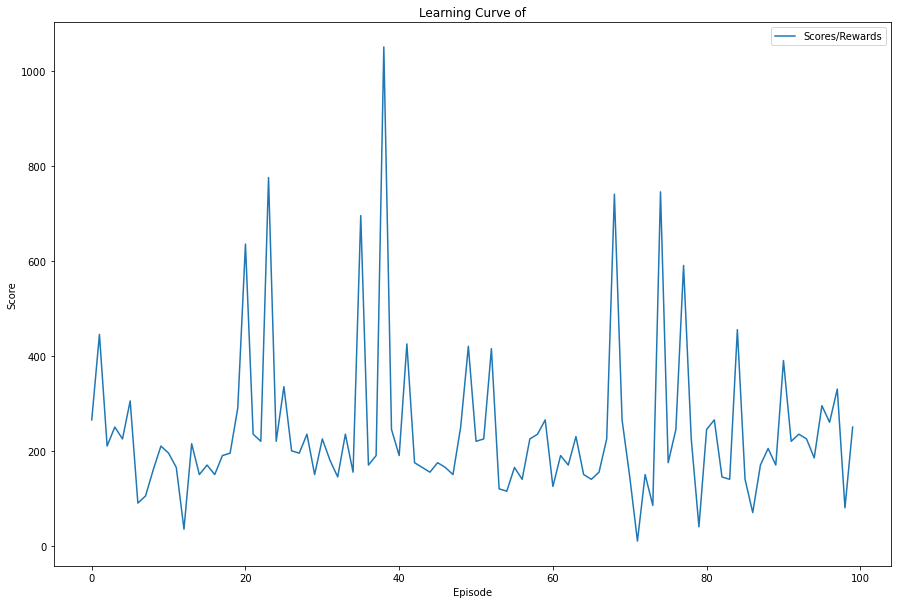

In [21]:
plt.figure(figsize=(15,10))
plt.plot(scores.history['episode_reward'], label = "Scores/Rewards")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Learning Curve of")
plt.legend(loc = "upper right")
plt.show()

## Using RMSprop as optimizers and BoltzmanQPolicy 

In [7]:
def agent2(model, actions):
    #policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    policy = BoltzmannQPolicy()
    #policy = LinearAnnealedPolicy(BoltzmannQPolicy(), attr='', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=100, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=10
                  )
    return dqn

In [8]:
dqn2 = agent2(model, actions)
dqn2.compile(RMSprop(lr=1e-4), metrics=['mae'])

/Users/nathan/opt/anaconda3/envs/machine_lr/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-12-09 04:12:31.820800: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
dqn2.fit(env, nb_steps=30, visualize=False, verbose=2)

Training for 30 steps ...


/Users/nathan/opt/anaconda3/envs/machine_lr/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/nathan/opt/anaconda3/envs/machine_lr/lib/python3.9/site-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


done, took 31.779 seconds


In [10]:
scores2 = dqn2.test(env, nb_episodes=10, visualize=True)
print(np.mean(scores2.history['episode_reward']))

Testing for 10 episodes ...


/Users/nathan/opt/anaconda3/envs/machine_lr/lib/python3.9/site-packages/gym/envs/atari/environment.py:255: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(
2021-12-09 04:13:07.394 python[1583:27076] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fab1ecf3ea0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-12-09 04:13:07.395 python[1583:27076] Warning: Expected min height of view: (<NSButton: 0x7faad21a9cc0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-12-09 04:13:07.398 python[1583:27076] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7faaeb59cee0>) to be less than or equal to 30 but got a heig

Episode 1: reward: 485.000, steps: 1029
Episode 2: reward: 575.000, steps: 1675
Episode 3: reward: 260.000, steps: 1099
Episode 4: reward: 265.000, steps: 1040
Episode 5: reward: 285.000, steps: 984
Episode 6: reward: 570.000, steps: 984
Episode 7: reward: 490.000, steps: 1232
Episode 8: reward: 335.000, steps: 995
Episode 9: reward: 280.000, steps: 846
Episode 10: reward: 485.000, steps: 1124
403.0


<Figure size 1080x720 with 0 Axes>

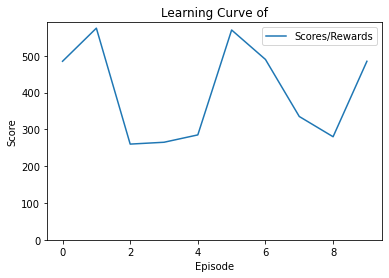

In [16]:
plt.figure(figsize=(15,10))
f, ax = plt.subplots()
plt.plot(scores2.history['episode_reward'], label = "Scores/Rewards")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Learning Curve of")
plt.legend(loc = "upper right")
ax.set_ylim(ymin=0)
plt.show()

# Loading Agent

In [ ]:
dqn.save_weights('SavedWeights/weight_2/dqn_weights.h5f')

In [12]:
del model, dqn

In [17]:
dqn.load_weights('SavedWeights/weight_1/dqn_weights.h5f')